# Token Probing Experiments

### Setup:

**Imports, Paths, GPU-Settings and Flags:**

In [9]:
import os
import jax
import pickle as pkl
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax.training import train_state
from typing import Dict, List
from matplotlib import cm, colors
from matplotlib.ticker import FormatStrFormatter

from configs.config import get_experiment_config, get_model_config
from src.training_init import TrainingInitializer
from src.util.internal_data_construction.tokenanalyser import TokenAnalyser
from src.util.internal_data_construction.nonlinear_feature_probe import NonlinearFeatureProbe

In [10]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
devices = jax.devices()

rerun_models = False
rerun_analyses = False
store_results = False

path_models_fully = 'experiment_results/linear_seq_fully/tokenanalysis_full_params.pkl'
path_partobs_all_models = 'experiment_results/linear_seq_partial/all_models.pkl'
path_model_nonlin_7 = 'experiment_results/nonlinear_seq_fully/model_sm_7l_fullfledged.pkl'
path_model_nonlin_mesa = 'experiment_results/nonlinear_seq_fully/model_mesa_fullfledged.pkl'

path_token_analysis_fully = 'experiment_results/linear_seq_fully/tokenanalysis_results.pkl'
path_token_analysis_partobs =  'experiment_results/linear_seq_partial/tokenanalysis_results.pkl'
path_token_analysis_nonlinear =  'experiment_results/nonlinear_seq_fully/tokenanalysis_results.pkl'

print(f'Running on Devices: {devices},\nRe-Run Analysis: {rerun_analyses}, \nRe-Run Models: {rerun_models}, \nStore Results: {store_results}')

Running on Devices: [CpuDevice(id=0)],
Re-Run Analysis: False, 
Re-Run Models: False, 
Store Results: False


## Models trained on fully observable linear dynamical systems:

In [13]:
models_full = {'full_seven_sm': 'fully_obs_full_fledged_transformer.6.4.40.50.20.True.False.False.False.0.False.False.0.False.False.False.False',
               'full_mesa':            'fully_obs_full_fledged_mesa.1.4.40.50.20.True.False.False.False.0.False.True.1.False.False.False.False',
               'just_mesa':                              'just_mesa.1.4.40.50.20.True.False.False.False.0.False.True.1.False.False.False.False'}
probe_token = 49
probe_range = 7

In [14]:
init_training_seed = 42
exp_config_fully = get_experiment_config(experiment='probing_full', seeds=[1, 11, 111, 1111, 11111])
if rerun_models:
    model_config_sm_fully = get_model_config(models_full['full_seven_sm'])
    model_config_mesa_fully = get_model_config(models_full['full_mesa'])
    (model_sm, optimizer_sm, data_generator_sm, train_module_sm) = TrainingInitializer(model_config=model_config_sm_fully,
                                                                                       experiment_config=exp_config_fully).run()
    (model_mesa, optimizer_mesa, data_generator_mesa, train_module_mesa) = TrainingInitializer(model_config=model_config_mesa_fully,
                                                                                               experiment_config=exp_config_fully).run()
    # Train Full Softmax Model:
    rng = jax.random.PRNGKey(init_training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_tf, rng = train_module_sm.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(200):
        state_tf, train_rng, _, _, _ = train_module_sm.train_epoch(epoch=epoch_idx,
                                                                   state=state_tf,
                                                                   rng=train_rng,
                                                                   test_rng=test_rng,
                                                                   num_batches_train=100,
                                                                   interpolate=False)
    # Train Hybrid-Mesa Model:
    rng = jax.random.PRNGKey(init_training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_mesa, rng = train_module_mesa.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(120):
        state_mesa, train_rng, _, _, _ = train_module_mesa.train_epoch(epoch=epoch_idx,
                                                                       state=state_mesa,
                                                                       rng=train_rng,
                                                                       test_rng=test_rng,
                                                                       num_batches_train=100,
                                                                       interpolate=False)
    # Train Just-Mesa Model:
    exp_config_fully.optim.peak_lr = 3e-4
    model_config_just_mesa = get_model_config(models_full['just_mesa'])
    (model_just_mesa, optimizer_mesa, data_generator_mesa, train_module_just_mesa) = TrainingInitializer(model_config=model_config_just_mesa,
                                                                                                         experiment_config=exp_config_fully).run()
    rng = jax.random.PRNGKey(init_training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_just_mesa, rng = train_module_just_mesa.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(35):
        state_just_mesa, train_rng, _, _, _ = train_module_just_mesa.train_epoch(epoch=epoch_idx,
                                                                                 state=state_just_mesa,
                                                                                 rng=train_rng,
                                                                                 test_rng=test_rng,
                                                                                 num_batches_train=100,
                                                                                 interpolate=False)
    params_dict = {'state_tf' : state_tf.params,
                   'state_mesa' : state_mesa.params,
                   'state_just_mesa': state_just_mesa.params}
    if store_results:
        print(f'Storing model paremeters in path=\'{path_models_fully}\'')
        with open(path_models_fully, 'wb') as handle:
            pkl.dump(params_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)   
else:
    with open(path_models_fully, 'rb') as handle:
        params_dict = pkl.load(handle)
    

In [15]:
tf_params = params_dict['state_tf']
mesa_params = params_dict['state_mesa']
just_mesa_params = params_dict['state_just_mesa']
exp_config_fully.experiment.probe_range = probe_range
models_sm, states_sm, models_mesa, states_mesa, models_just_mesa, states_just_mesa = [],[],[],[],[],[]

model_config_partobs_SM = get_model_config(models_full['full_seven_sm'])
model_config_partobs_Mesa = get_model_config(models_full['full_mesa'])
model_config_partobs_Just_Mesa = get_model_config(models_full['just_mesa'])
(model_sm, optimizer_sm, data_generator_sm, _) = TrainingInitializer(model_config=model_config_partobs_SM,
                                                        experiment_config=exp_config_fully).run()
(model_mesa, optimizer_mesa, data_generator_mesa, _) = TrainingInitializer(model_config=model_config_partobs_Mesa,
                                                                experiment_config=exp_config_fully).run()
(model_just_mesa, optimizer_just_mesa, data_generator_just_mesa, _) = TrainingInitializer(model_config=model_config_partobs_Just_Mesa,
                                                                            experiment_config=exp_config_fully).run()

state_tf = train_state.TrainState.create(apply_fn=model_sm.apply, params=tf_params, tx=optimizer_sm)
state_mesa = train_state.TrainState.create(apply_fn=model_mesa.apply, params=mesa_params, tx=optimizer_mesa)
state_just_mesa = train_state.TrainState.create(apply_fn=model_just_mesa.apply, params=just_mesa_params, tx=optimizer_just_mesa)
models_sm.append(model_sm)
models_mesa.append(model_mesa)
models_just_mesa.append(model_just_mesa)
states_sm.append(state_tf)
states_mesa.append(state_mesa)
states_just_mesa.append(state_just_mesa)
token_analysis_sm = TokenAnalyser(models=models_sm, 
                                  states=states_sm, 
                                  data_generator=data_generator_sm, 
                                  experiment_config=exp_config_fully,
                                  r2=False)
token_analysis_mesa = TokenAnalyser(models=models_mesa, 
                                  states=states_mesa, 
                                  data_generator=data_generator_mesa, 
                                  experiment_config=exp_config_fully,
                                  r2=False)
token_analysis_just_mesa = TokenAnalyser(models=models_just_mesa, 
                                  states=states_just_mesa, 
                                  data_generator=data_generator_just_mesa, 
                                  experiment_config=exp_config_fully,
                                  r2=False)

model:  fully_obs_full_fledged_transformer  layers: 6  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  False  clip_val:  0
model:  fully_obs_full_fledged_mesa  layers: 1  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  True  clip_val:  1
model:  just_mesa  layers: 1  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  True  clip_val:  1


In [16]:
if rerun_analyses:
    fully_dict_sm = token_analysis_sm.run(probe_token)
    fully_dict_mesa = token_analysis_mesa.run(probe_token)
    fully_dict_just_mesa = token_analysis_just_mesa.run(probe_token)
    if store_results:
        print(f'Storing token analysis result-dicts in path=\'{path_token_analysis_fully}\'')
        results = {'fully_dict_sm' : fully_dict_sm,
                   'fully_dict_mesa' : fully_dict_mesa,
                   'fully_dict_just_mesa': fully_dict_just_mesa}
        with open(path_token_analysis_fully, 'wb') as handle:
            pkl.dump(results, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_token_analysis_fully, 'rb') as handle:
        res_dict = pkl.load(handle)
    fully_dict_sm, fully_dict_mesa, fully_dict_just_mesa = res_dict['fully_dict_sm'], res_dict['fully_dict_mesa'], res_dict['fully_dict_just_mesa']
sm_mean_f, sm_svs_f = fully_dict_sm['results_means'], fully_dict_sm['results_svs']
mesa_mean_f, mesa_svs_f = fully_dict_mesa['results_means'], fully_dict_mesa['results_svs']
just_mesa_mean_f, just_mesa_svs_f = fully_dict_just_mesa['results_means'], fully_dict_just_mesa['results_svs']

## Models trained on partially observable linear dynamical systems:

In [11]:
sm_model_def = lambda dim : f'part_obs_full_fledged_transformer.6.12.{dim}.50.{min(20,dim)}.True.False.False.False.0.False.False.0.False.False.False.False'
mesa_model_def = lambda dim : f'part_obs_full_fledged_mesa.1.12.{dim}.50.{min(20,dim)}.True.False.False.False.0.False.True.1.False.False.False.False'

probe_token = 49
probe_range = 7

In [12]:
if rerun_models:
    params_list_sm_partobs = []
    params_list_mesa_partobs = []
    init_training_seed = 42
    exp_config_partobs = get_experiment_config(experiment='partobs', seeds=[1, 11, 111, 1111, 11111])
    for dimension in [5, 10, 15, 20, 30, 50, 80]:
        model_config_sm_partobs = get_model_config(sm_model_def(dimension))
        model_config_mesa_partobs = get_model_config(mesa_model_def(dimension))
        (model_sm, optimizer_sm, data_generator_sm, train_module_sm) = TrainingInitializer(model_config=model_config_partobs_SM,
                                                                                           experiment_config=exp_config_partobs).run()
        (model_mesa, optimizer_mesa, data_generator_mesa, train_module_mesa) = TrainingInitializer(model_config=model_config_partobs_Mesa,
                                                                                                   experiment_config=exp_config_partobs).run()
        # Train Full Softmax Model:
        rng = jax.random.PRNGKey(init_training_seed)
        rng, test_rng, train_rng = jax.random.split(rng, 3)
        state_tf, rng = train_module_sm.get_init_state(rng, interpol_call=False)
        for epoch_idx in range(200):
            state_tf, train_rng, _, _, _ = train_module_sm.train_epoch(epoch=epoch_idx,
                                                                       state=state_tf,
                                                                       rng=train_rng,
                                                                       test_rng=test_rng,
                                                                       num_batches_train=100,
                                                                       interpolate=False)
        # Train Hybrid-Mesa Model:
        rng = jax.random.PRNGKey(init_training_seed)
        rng, test_rng, train_rng = jax.random.split(rng, 3)
        state_mesa, rng = train_module_mesa.get_init_state(rng, interpol_call=False)
        for epoch_idx in range(120):
            state_mesa, train_rng, _, _, _ = train_module_mesa.train_epoch(epoch=epoch_idx,
                                                                           state=state_mesa,
                                                                           rng=train_rng,
                                                                           test_rng=test_rng,
                                                                           num_batches_train=100,
                                                                           interpolate=False)
        params_list_sm_partobs.append(state_tf.params)
        params_list_mesa_partobs.append(state_mesa.params)
        if store_results:
                print(f'Storing model paremeters in path=\'{path_partobs_all_models}\'')
                results = {'partobs_models_sm' : params_list_sm_partobs,
                        'partobs_models_mesa' : params_list_mesa_partobs}
                with open(path_partobs_all_models, 'wb') as handle:
                        pkl.dump(results, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_partobs_all_models, 'rb') as handle:
        params_dict = pkl.load(handle)
    params_list_sm_partobs = params_dict['partobs_models_sm']
    params_list_mesa_partobs = params_dict['partobs_models_mesa']

    exp_config_partobs = get_experiment_config(experiment='partobs', seeds=[1, 11, 111, 1111, 11111])
    models_sm, states_sm, models_mesa, states_mesa = [],[],[],[]
    for i, dim in enumerate([5, 10, 15, 20, 30, 50, 80]):
        model_config_partobs_SM = get_model_config(sm_model_def(dim))
        model_config_partobs_Mesa = get_model_config(mesa_model_def(dim))
        (model_sm, optimizer_sm, data_generator_sm, _) = TrainingInitializer(model_config=model_config_partobs_SM,
                                                                             experiment_config=exp_config_partobs).run()
        (model_mesa, optimizer_mesa, data_generator_mesa, _) = TrainingInitializer(model_config=model_config_partobs_Mesa,
                                                                                   experiment_config=exp_config_partobs).run()
        state_tf = train_state.TrainState.create(apply_fn=model_sm.apply, params=params_list_sm_partobs[i], tx=optimizer_sm)
        state_mesa = train_state.TrainState.create(apply_fn=model_mesa.apply, params=params_list_mesa_partobs[i], tx=optimizer_mesa)
        models_sm.append(model_sm)
        models_mesa.append(model_mesa)
        states_sm.append(state_tf)
        states_mesa.append(state_mesa)

model:  part_obs_full_fledged_transformer  layers: 6  heads:  12  embed_dim:  5  seq_len:  50  key_size:  5  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  False  clip_val:  0
model:  part_obs_full_fledged_mesa  layers: 1  heads:  12  embed_dim:  5  seq_len:  50  key_size:  5  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  True  clip_val:  1
model:  part_obs_full_fledged_transformer  layers: 6  heads:  12  embed_dim:  10  seq_len:  50  key_size:  10  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  False  clip_val:  0
model:  part_obs_full_fledged_mesa  layers: 1  heads:  12  embed_dim:  10  seq_len:  50  key_size:  10  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  True  clip_val:  1
model:  part_obs_full_fledged_transformer  layers: 6  heads:  12  embed_dim:  15  seq_len:  50  key_size:  15  p

In [17]:
token_analysis_sm = TokenAnalyser(models=[models_sm[-1]], 
                                  states=[states_sm[-1]], 
                                  data_generator=data_generator_sm, 
                                  experiment_config=exp_config_partobs,
                                  r2=False)
token_analysis_mesa = TokenAnalyser(models=[models_mesa[-1]], 
                                  states=[states_mesa[-1]], 
                                  data_generator=data_generator_mesa, 
                                  experiment_config=exp_config_partobs,
                                  r2=False)

In [18]:
if rerun_analyses:
    partobs_dict_sm = token_analysis_sm.run(probe_token)
    partobs_dict_mesa = token_analysis_mesa.run(probe_token)
    if store_results:
        print(f'Storing token analysis result-dicts in path=\'{path_token_analysis_partobs}\'')
        results = {'partobs_dict_sm' : partobs_dict_sm,
                   'partobs_dict_mesa' : partobs_dict_mesa}
        with open(path_token_analysis_fully, 'wb') as handle:
            pkl.dump(results, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_token_analysis_partobs, 'rb') as handle:
        res_dict = pkl.load(handle)
    partobs_dict_sm, partobs_dict_mesa = res_dict['partobs_dict_sm'], res_dict['partobs_dict_mesa']
sm_mean_p, sm_svs_p = partobs_dict_sm['results_means'], partobs_dict_sm['results_svs']
mesa_mean_p, mesa_svs_p = partobs_dict_mesa['results_means'], partobs_dict_mesa['results_svs']

## Models trained on fully observable nonlinear dynamical systems:

In [19]:
models_nonlin = {'nonlin_seven_sm': 'nonlinear_full_fledged_transformer.6.4.60.50.20.True.False.False.True.300.False.False.0.True.False.False.False',
                 'nonlin_mesa':            'fully_obs_full_fledged_mesa.1.4.60.50.20.True.False.False.True.300.False.True.15.True.False.False.False'}

probe_token = 49
probe_range = 7

In [20]:
exp_config_nonlin = get_experiment_config('nonlin', seeds=[1,11,111,1111,11111])
(model_tf_nonlin, optimizer, data_generator_nonlin, train_module_tf) = TrainingInitializer(model_config=get_model_config(models_nonlin['nonlin_seven_sm']), 
                                                                                           experiment_config=exp_config_nonlin).run()
(model_mesa_nonlin, optimizer, data_generator_nonlin, train_module_mesa) = TrainingInitializer(model_config=get_model_config(models_nonlin['nonlin_mesa']), 
                                                                                               experiment_config=exp_config_nonlin).run()
if rerun_models:
    training_seed = 1
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_tf_nonlin, rng = train_module_tf.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(400):
        state_tf_nonlin, train_rng, _, _, _ = train_module_tf.train_epoch(epoch=epoch_idx,
                                                                          state=state_tf_nonlin,
                                                                          rng=train_rng,
                                                                          test_rng=test_rng,
                                                                          num_batches_train=100,
                                                                          interpolate=False)
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_mesa_nonlin, rng = train_module_mesa.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(400):
        state_mesa_nonlin, train_rng, _, _, _ = train_module_mesa.train_epoch(epoch=epoch_idx,
                                                                              state=state_mesa_nonlin,
                                                                              rng=train_rng,
                                                                              test_rng=test_rng,
                                                                              num_batches_train=100,
                                                                              interpolate=False)
    if store_results:
        print(f'Storing nonlin. softmax-tf in path=\'{path_model_nonlin_7}\'')
        a = {'params' : state_tf_nonlin.params}
        with open(path_model_nonlin_7, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
        print(f'Storing nonlin. mesa parameters in path=\'{path_model_nonlin_mesa}\'')
        b = {'params' : state_mesa_nonlin.params}
        with open(path_model_nonlin_mesa, 'wb') as handle:
            pkl.dump(b, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_nonlin_7, 'rb') as handle:
        a = pkl.load(handle)
    with open(path_model_nonlin_mesa, 'rb') as handle:
        b = pkl.load(handle)
    state_tf_nonlin = train_state.TrainState.create(apply_fn=model_tf_nonlin.apply, params=a['params'], tx=optimizer)
    state_mesa_nonlin = train_state.TrainState.create(apply_fn=model_mesa_nonlin.apply, params=b['params'], tx=optimizer)

model:  nonlinear_full_fledged_transformer  layers: 6  heads:  4  embed_dim:  60  seq_len:  50  key_size:  20  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  True  dim_mlp:  300  linear:  False  clip:  False  clip_val:  0
model:  fully_obs_full_fledged_mesa  layers: 1  heads:  4  embed_dim:  60  seq_len:  50  key_size:  20  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  True  dim_mlp:  300  linear:  False  clip:  True  clip_val:  15


In [21]:
exp_config_partobs.experiment.probe_range = probe_range
models_sm, states_sm, models_mesa, states_mesa, = [],[],[],[]
models_sm.append(model_tf_nonlin)
models_mesa.append(model_mesa_nonlin)
states_sm.append(state_tf_nonlin)
states_mesa.append(state_mesa_nonlin)

if rerun_analyses:
    all_results = []
    for layer in range(7):
        token_analysis_sm = TokenAnalyser(models=models_sm, 
                                          states=states_sm, 
                                          data_generator=data_generator_sm, 
                                          experiment_config=exp_config_partobs,
                                          nonlinear=True,
                                          layer=layer)
        token_analysis_mesa = TokenAnalyser(models=models_mesa, 
                                            states=states_mesa, 
                                            data_generator=data_generator_mesa, 
                                            experiment_config=exp_config_partobs,
                                            nonlinear=True,
                                            layer=min(layer, 2))
        nonlin_dict_sm = token_analysis_sm.run(probe_token)
        nonlin_dict_mesa = token_analysis_mesa.run(probe_token)
        results = {'nonlin_dict_sm' : nonlin_dict_sm,
                   'nonlin_dict_mesa' : nonlin_dict_mesa}
        all_results.append(results)
    if store_results:
        print(f'Storing token probing results for nonlin in path=\'{path_token_analysis_nonlinear}\'')
        results = {'all_results' : all_results}
        with open(path_token_analysis_nonlinear, 'wb') as handle:
            pkl.dump(all_results, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_token_analysis_nonlinear, 'rb') as handle:
        all_results_nonlin = pkl.load(handle)['all_results']
    nonlin_dict_sm, nonlin_dict_mesa = all_results_nonlin[1]['partobs_dict_sm'], all_results_nonlin[1]['partobs_dict_mesa']
    sm_mean_n, sm_svs_n = nonlin_dict_sm['results_means'], nonlin_dict_sm['results_svs']
    mesa_mean_n, mesa_svs_n = nonlin_dict_mesa['results_means'], nonlin_dict_mesa['results_svs']

## Visualization of Results:

([<matplotlib.lines.Line2D object at 0x0000021431A3A7C0>], ['Hybrid-mesa'])


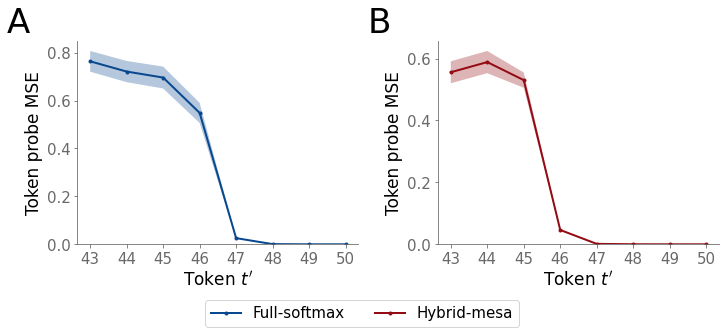

In [44]:
def subplot_partobs(ax,
                    col_f,
                    results_means_f: List[jnp.ndarray],
                    results_svs_f: List[jnp.ndarray],
                    token_index: int,
                    analysis_range: int,
                    name: str):
    c = col_f
    ax.plot(results_means_f[-1], label=f'{name}', linestyle='solid', linewidth=2, color=c, marker='.')
    ax.fill_between(range(results_means_f[-1].shape[0]), (results_means_f[-1]-results_svs_f[-1]), (results_means_f[-1]+results_svs_f[-1]), alpha=0.3, facecolor=c)

    ax.set_ylim(0,)
    ax.set_xlabel('Token $t\'$')
    ax.set_xticks(range(analysis_range+1),jnp.arange(token_index-analysis_range,token_index+1))
    ax.set_ylabel(f'Token probe MSE')
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['left'].set_color('dimgray')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

def plot_token_analysis(partobs_range: int,
                        sm_mean: List[jnp.ndarray],
                        sm_svs: List[jnp.ndarray],
                        mesa_mean: List[jnp.ndarray],
                        mesa_svs: List[jnp.ndarray],
                        mesa_j_mean: List[jnp.ndarray],
                        mesa_j_svs: List[jnp.ndarray],
                        token_index: int):

    plt.rcParams.update({'font.size': 15})
    plt.rc('axes', labelsize=17)
    plt.rcParams.update({
        "text.usetex": False,
    })

    num_graphs = 8
    colormap_sm, colormap_mesa, colormap_just_mesa = tuple([plt.get_cmap(col, 100) for col in ['Blues', 'Reds', 'Purples']])
    subplot_col_fn = lambda colmap : [colmap(i) for i in [10+(80//num_graphs)*(k+1) for k in range(num_graphs)]]

    fig, axs = plt.subplots(nrows=1,
                            ncols=3 if mesa_j_mean is not None else 2,
                            figsize=(14, 4) if mesa_j_mean is not None else (10, 4),
                            gridspec_kw={'width_ratios': [1,1,1] if mesa_j_mean is not None else [1,1]},
                            layout='constrained')

    ################################################
    subplot_partobs(ax=axs[0],
                    col_f = subplot_col_fn(colormap_sm)[-1],
                    results_means_f = sm_mean,
                    results_svs_f = sm_svs,
                    token_index=token_index,
                    analysis_range=partobs_range,
                    name='Full-softmax')
    subplot_partobs(ax=axs[1],
                    col_f=subplot_col_fn(colormap_mesa)[-1],
                    results_means_f = mesa_mean,
                    results_svs_f = mesa_svs,
                    token_index=token_index,
                    analysis_range=partobs_range,
                    name='Hybrid-mesa')
    if mesa_j_mean is not None:
        subplot_partobs(ax=axs[2],
                        col_f=subplot_col_fn(colormap_just_mesa)[-1],
                        results_means_f = mesa_j_mean,
                        results_svs_f = mesa_j_svs,
                        token_index=token_index,
                        analysis_range=partobs_range,
                        name='Full-mesa')
    ################################################
    # Legend:
    handles = (axs[0].get_legend_handles_labels()[0] + axs[1].get_legend_handles_labels()[0] + axs[2].get_legend_handles_labels()[0]) if mesa_j_mean is not None else (axs[0].get_legend_handles_labels()[0] + axs[1].get_legend_handles_labels()[0])
    labels = (axs[0].get_legend_handles_labels()[1] + axs[1].get_legend_handles_labels()[1] + axs[2].get_legend_handles_labels()[1]) if mesa_j_mean is not None else (axs[0].get_legend_handles_labels()[1] + axs[1].get_legend_handles_labels()[1])
    print(axs[1].get_legend_handles_labels())
    l5 = fig.legend(handles, labels, bbox_to_anchor=(0.5, 0), loc="upper center",
                    bbox_transform=fig.transFigure, ncol=4, fontsize='medium',
                    frameon=True)
    
    label_size = 34
    axs[0].text(-0.25, 1.17, 'A', transform=axs[0].transAxes, fontsize=label_size, va='top')
    axs[1].text(-0.25, 1.17, 'B', transform=axs[1].transAxes, fontsize=label_size, va='top')
    if mesa_j_mean is not None:
        axs[2].text(-0.25, 1.17, 'C', transform=axs[2].transAxes, fontsize=label_size, va='top')
    if store_results:
        fig.savefig('fully_token_apx.pdf', bbox_inches='tight', pad_inches=0.1)
        
    plt.show()

plot_token_analysis(partobs_range=probe_range,
                    sm_mean=sm_mean_p,
                    sm_svs=sm_svs_p,
                    mesa_mean=mesa_mean_p,
                    mesa_svs=mesa_svs_p,
                    mesa_j_mean=None,
                    mesa_j_svs=None,
                    token_index=50)

**Figure 2 from Paper:**

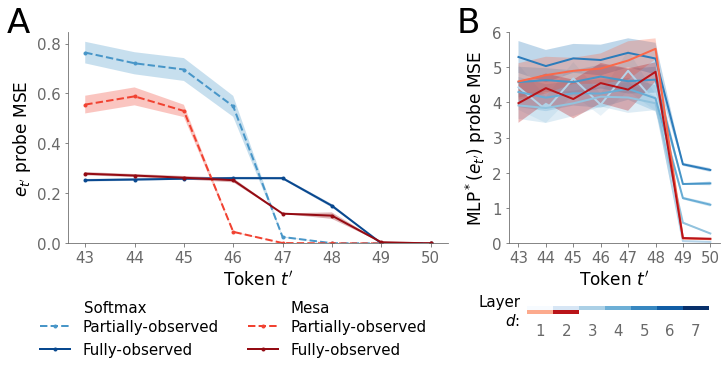

In [23]:
def subplot_partobs_nonlinear(ax,
                                cols,
                                results_means_f: List[jnp.ndarray],
                                results_svs_f: List[jnp.ndarray],
                                token_index: int,
                                analysis_range: int,
                                linestyle: str,
                                n_layers: int,
                                all_results: List,
                                name: str):
    
    for i in range(n_layers):
        results = all_results[i]
        partobs_dict = results['partobs_dict_sm'] if name == 'Full-softmax-80d.' else results['partobs_dict_mesa']
        results_means_f, results_svs_f = partobs_dict['results_means'], partobs_dict['results_svs']
        c = cols[i]
        ax.plot(results_means_f[-1], label=f'{name}', linestyle='solid', linewidth=2, color=c)
        ax.fill_between(range(results_means_f[-1].shape[0]), (results_means_f[-1]-results_svs_f[-1]), (results_means_f[-1]+results_svs_f[-1]), alpha=0.3, facecolor=c)

    ax.set_ylim(0,6)
    ax.set_xlabel('Token $t^\prime$')
    ax.set_xticks(range(analysis_range+1),jnp.arange(token_index-analysis_range,token_index+1))
    ax.set_ylabel('MLP$^*(e_{t^\prime})$ probe MSE')
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['left'].set_color('dimgray')

def subplot_partobs(ax,
                    col,
                    col_f,
                    results_means: List[jnp.ndarray],
                    results_svs: List[jnp.ndarray],
                    results_means_f: List[jnp.ndarray],
                    results_svs_f: List[jnp.ndarray],
                    token_index: int,
                    analysis_range: int,
                    linestyle: str,
                    name: str):
    c = col
    ax.plot(results_means[-1], label=f'Partially-observed', linestyle='dashed', linewidth=2, color=c, marker='.')
    ax.fill_between(range(results_means[-1].shape[-1]), (results_means[-1]-results_svs[-1]), (results_means[-1]+results_svs[-1]), alpha=0.3, facecolor=c)
    c = col_f
    ax.plot(results_means_f[-1], label=f'Fully-observed', linestyle='solid', linewidth=2, color=c, marker='.')
    ax.fill_between(range(results_means_f[-1].shape[0]), (results_means_f[-1]-results_svs_f[-1]), (results_means_f[-1]+results_svs_f[-1]), alpha=0.3, facecolor=c)

    ax.set_ylim(0,)
    ax.set_xlabel('Token $t\'$')
    ax.set_xticks(range(analysis_range+1),jnp.arange(token_index-analysis_range,token_index+1))
    ax.set_ylabel('$e_{t^\prime}$ probe MSE')
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')
    #ax.legend(fontsize='small', loc=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['left'].set_color('dimgray')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

def plot_fig2(sm_mean: List[jnp.ndarray],
                sm_svs: List[jnp.ndarray],
                mesa_mean: List[jnp.ndarray],
                mesa_svs: List[jnp.ndarray],
                partobs_range: int,
                sm_mean_f: List[jnp.ndarray],
                sm_svs_f: List[jnp.ndarray],
                mesa_mean_f: List[jnp.ndarray],
                mesa_svs_f: List[jnp.ndarray],
                token_index: int,
                all_results_nonlin: List[Dict[str, jnp.ndarray]]):

    plt.rcParams.update({'font.size': 15})
    plt.rc('axes', labelsize=17)
    plt.rcParams.update({
        "text.usetex": False,
    })

    num_graphs = 8
    colormap_sm, colormap_mesa, colormap_grey = tuple([plt.get_cmap(col, 100) for col in ['Blues', 'Reds', 'Greys']])
    subplot_col_fn = lambda colmap : [colmap(i) for i in [10+(80//num_graphs)*(k+1) for k in range(num_graphs)]]
    special_mesa_nonlin_col = [colormap_mesa(20), colormap_mesa(50), colormap_mesa(80)]

    fig, axs = plt.subplots(nrows=1,
                            ncols=2,
                            figsize=(10, 4),
                            gridspec_kw={'width_ratios': [1.8,1]},
                            layout='constrained')

    ################################################
    ################################################
    # Part. Obs. - Analyses:
    subplot_partobs(ax=axs[0],
                    col=subplot_col_fn(colormap_sm)[-4],
                    col_f = subplot_col_fn(colormap_sm)[-1],
                    results_means=sm_mean,
                    results_svs=sm_svs,
                    results_means_f = sm_mean_f,
                    results_svs_f = sm_svs_f,
                    token_index=token_index,
                    analysis_range=partobs_range,
                    linestyle='dotted',
                    name='softmax')
    subplot_partobs(ax=axs[0],
                    col=subplot_col_fn(colormap_mesa)[-4],
                    col_f=subplot_col_fn(colormap_mesa)[-1],
                    results_means=mesa_mean,
                    results_svs=mesa_svs,
                    results_means_f = mesa_mean_f,
                    results_svs_f = mesa_svs_f,
                    token_index=token_index,
                    analysis_range=partobs_range,
                    linestyle='dotted',
                    name='mesa')
    ################################################
    # Nonlin. - Analyses:
    subplot_partobs_nonlinear(ax=axs[1],
                    cols = subplot_col_fn(colormap_sm),
                    results_means_f = sm_mean_f,
                    results_svs_f = sm_svs_f,
                    token_index=token_index,
                    analysis_range=partobs_range,
                    linestyle='solid',
                    all_results=all_results_nonlin,
                    n_layers=6,
                    name='Full-softmax-80d.')
    subplot_partobs_nonlinear(ax=axs[1],
                    cols=special_mesa_nonlin_col,
                    results_means_f = mesa_mean_f,
                    results_svs_f = mesa_svs_f,
                    token_index=token_index,
                    analysis_range=partobs_range,
                    linestyle='solid',
                    all_results=all_results_nonlin,
                    n_layers=3,
                    name='Hybrid-mesa-80d.')

    # Corresponding Colorbar:
    def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
      new_cmap = colors.LinearSegmentedColormap.from_list(
          'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
          cmap(jnp.linspace(minval, maxval, n))
      )
      return new_cmap

    # Truncate the colormap
    new_colormap_mesa = truncate_colormap(colormap_mesa, 0.3, 0.8)

    box = axs[1].get_position()
    cbar_height = 0.015  # Height of each colorbar
    space_between = 0.0  # Space between colorbars and subplot
    cbar_offset = 0.19  # Total offset from the bottom of the subplot to the top colorbar
    cbar_ax1 = fig.add_axes([box.x0+0.08, box.y0 - cbar_offset, box.width, cbar_height])
    cbar_ax2 = fig.add_axes([box.x0+0.08, box.y0 - (cbar_offset + cbar_height), (box.width/7)*2, cbar_height])

    cmap = colormap_sm
    bounds = [43, 44, 45, 46, 47, 48, 49, 50]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    norm2 = colors.BoundaryNorm([0,1,2], new_colormap_mesa.N)
    cs1 = fig.colorbar(mappable=cm.ScalarMappable(norm=norm, cmap=colormap_sm),
                 orientation='horizontal',
                 cax=cbar_ax1)
    cs2 = fig.colorbar(mappable=cm.ScalarMappable(norm=norm2, cmap=new_colormap_mesa),
                 orientation='horizontal',
                 cax=cbar_ax2)
    cs2.ax.set_xticklabels([])
    cs2.ax.set_xticks([])

    mid_points = [(bounds[i] + bounds[i + 1]) / 2 for i in range(len(bounds) - 1)]
    cs1.set_ticks(mid_points)
    cs1.set_ticklabels(["$1$", "$2$", "$3$", "$4$","$5$","$6$","$7$"],color='dimgray')
    cs1.ax.xaxis.set_tick_params(pad=+12)

    cbar_ax1.set_frame_on(False)
    cbar_ax2.set_frame_on(False)
    cbar_ax1.xaxis.set_tick_params(size=0)
    label_y_position = box.y0 - cbar_offset - (cbar_height / 2) - space_between / 2
    fig.text(box.x0 + 0.07, label_y_position+0.005, 'Layer\n$d$:', va='center', ha='right', rotation='horizontal')

    handles, labels = axs[0].get_legend_handles_labels()
    plt.annotate('Softmax', xy=(0.16, 0.2), xycoords='figure fraction', fontsize='medium', fontweight=400, ha='center')
    plt.annotate('Mesa', xy=(0.431, 0.2), xycoords='figure fraction', fontsize='medium', fontweight=400, ha='center')
    l5 = fig.legend(handles, labels, bbox_to_anchor=(0.32, -0.05), loc="upper center",
                    bbox_transform=fig.transFigure, ncol=2, fontsize='medium',
                    frameon=False)
    
    label_size = 34  # Size of the labels
    axs[0].text(-0.16, 1.12, 'A', transform=axs[0].transAxes, fontsize=label_size, va='top')
    axs[1].text(-0.25, 1.12, 'B', transform=axs[1].transAxes, fontsize=label_size, va='top')


    ################################################
    if store_results:
        fig.savefig('internal_dataset_creation.pdf', bbox_inches='tight', pad_inches=0.1)
    plt.show()

plot_fig2(sm_mean = sm_mean_p,
          sm_svs = sm_svs_p,
          mesa_mean = mesa_mean_p,
          mesa_svs = mesa_svs_p,
          partobs_range = probe_range,
          sm_mean_f = sm_mean_f,
          sm_svs_f = sm_svs_f,
          mesa_mean_f = mesa_mean_f,
          mesa_svs_f = mesa_svs_f,
          token_index = 50,
          all_results_nonlin = all_results_nonlin)